In [ ]:
!pip install seaborn

In [ ]:
!pip install tqdm

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_scheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from tqdm import tqdm

In [ ]:
from google.colab import drive
import pandas as pd

drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/SKRIPSI/dataset_full_label.csv'

df = pd.read_csv(file_path)
df

Mounted at /content/drive


,publishedAt,authorDisplayName,textDisplay,likeCount,Label Kelas,cleaned_text,teks normalisasi,stop_word,lemmatized_text,tokenized_text
0,2024-08-30T22:09:42Z,@FeryFlayfree,jika memang ada pejabat yang baik atau benar d...,0,others,jika memang ada pejabat yang baik atau benar d...,jika memang ada pejabat yang baik atau benar d...,pejabat baik benar memiliki sifat pejuang terh...,jabat baik benar milik sifat juang hadap negar...,"['jabat', 'baik', 'benar', 'milik', 'sifat', '..."
1,2024-05-31T09:49:52Z,@triwahyulu,Sampe sekarang masih bisa tuh co di tiktok gimna,0,kontra,sampe sekarang masih bisa tuh co di tiktok gimna,sampe sekarang masih bisa tuh checkout di tikt...,sekarang bisa checkout tiktok gimana,sekarang bisa checkout tiktok gimana,"['sekarang', 'bisa', 'checkout', 'tiktok', 'gi..."
2,2024-04-23T17:26:47Z,@jateee999,"mengakali aturan wkwkw, kirain bahas kasus yg ...",0,netral,mengakali aturan wkwkw kirain bahas kasus yg ...,mengakali aturan ketawaw kirain bahas kasus ya...,mengakali aturan kirain bahas kasus lebih gede,akal atur kirain bahas kasus lebih gede,"['akal', 'atur', 'kirain', 'bahas', 'kasus', '..."
3,2024-04-08T23:42:56Z,@PrimantoRaya,dari konten ini judul apa yang bisa di ambil ...,0,netral,dari konten ini judul apa yang bisa di ambil ...,dari konten ini judul apa yang bisa di ambil t...,konten judul bisa ambil terkait manajeen keuan...,konten judul bisa ambil kait manajeen uang bang,"['konten', 'judul', 'bisa', 'ambil', 'kait', '..."
4,2024-04-08T15:33:47Z,@abiyasha6709,hore komennya 1k pas,0,others,hore komennya k pas,hore komennya k pas,hore komennya k pas,hore komennya k pas,"['hore', 'komennya', 'k', 'pas']"
...,...,...,...,...,...,...,...,...,...,...
4431,2023-09-18T05:16:33Z,@arukaaruka4882,Me too,2,others,me too,me too,me too,me too,"['me', 'too']"
4432,2023-09-18T05:18:34Z,@Akashina-chan,"1 billion people from around the world: , does...",1,others,billion people from around the world does...,billion people from around the world does you ...,billion people from around world does you are ...,billion people from around world does you are ...,"['billion', 'people', 'from', 'around', 'world..."
4433,2023-09-18T05:54:32Z,@rzkiramdhan7,"Cobain dh, seru!! Gua jg dulu anti tiktok tapi...",1,others,cobain dh seru gua jg dulu anti tiktok tapi...,cobain dah seru gua juga dulu anti tiktok tapi...,cobain seru gua dulu anti tiktok tapi stelah m...,cobain seru gua dulu anti tiktok tapi stelah m...,"['cobain', 'seru', 'gua', 'dulu', 'anti', 'tik..."
4434,2023-09-18T05:00:59Z,@dr.costanrumapea5336,Pertama,0,others,pertama,pertama,pertama,pertama,['pertama']


In [ ]:
labels = df['Label Kelas'].unique() # Changed 'Label_Kelas' to 'Label Kelas'
print(f"Labels found: {labels}")

label2id = {label: idx for idx, label in enumerate(labels)}
id2label = {idx: label for label, idx in label2id.items()}
df['label_id'] = df['Label Kelas'].map(label2id) # Changed 'Label_Kelas' to 'Label Kelas'

Labels found: ['others' 'kontra' 'netral' 'pro']


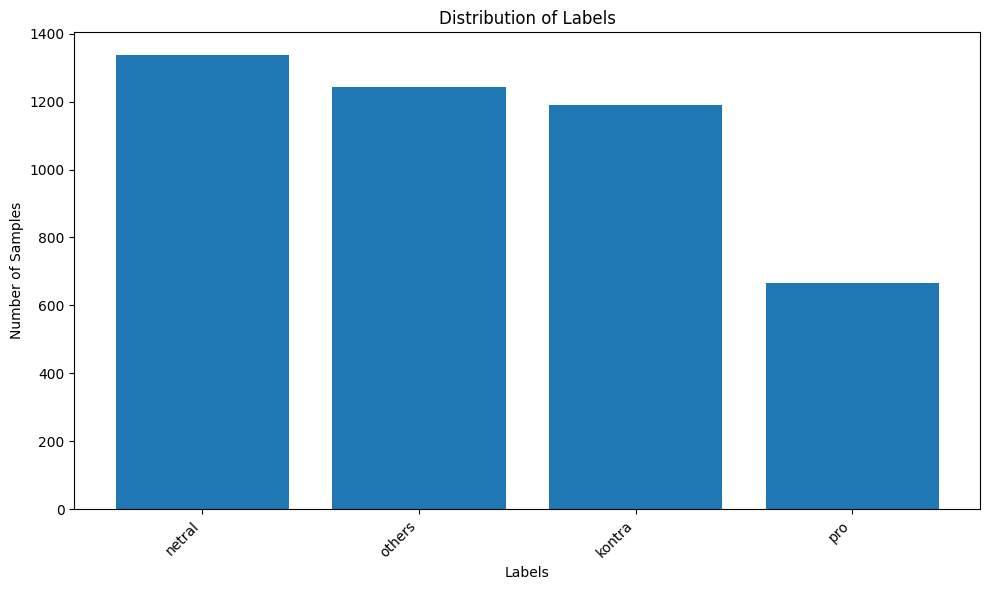

In [ ]:
label_counts = df['Label Kelas'].value_counts()

# Create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(label_counts.index, label_counts.values)
plt.xlabel("Labels")
plt.ylabel("Number of Samples")
plt.title("Distribution of Labels")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

In [ ]:
# Split dataset jadi train dan validation (misal 80:20)
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['lemmatized_text'].tolist(), df['label_id'].tolist(), test_size=0.2, random_state=42, stratify=df['label_id']
)

In [ ]:
# Load tokenizer IndoBERT (contoh model: 'indobenchmark/indobert-base-p1')
tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p1")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
# Dataset custom untuk PyTorch
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
# encoding keys are batch size 1, so squeeze dim 0
        item = {key: val.squeeze(0) for key, val in encoding.items()}
        item['labels'] = torch.tensor(label)
        return item
# Buat dataset dan dataloader
train_dataset = SentimentDataset(train_texts, train_labels, tokenizer)
val_dataset = SentimentDataset(val_texts, val_labels, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

num_labels = len(labels)
model = AutoModelForSequenceClassification.from_pretrained("indobenchmark/indobert-base-p1", num_labels=num_labels)

# Check if GPU is available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device) # Now 'device' is defined

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
# Optimizer dan scheduler
optimizer = AdamW(model.parameters(), lr=2e-5)
num_epochs = 5
num_training_steps = num_epochs * len(train_loader)
lr_scheduler = get_scheduler(
    name="linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

In [ ]:
# Training Loop
progress_bar = tqdm(range(num_training_steps))

train_losses = []  # List to store training losses
val_losses = []  # List to store validation losses
val_accuracies = []  # List to store validation accuracies

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)  # Append average training loss for the epoch

        # Validasi
    model.eval()
    all_preds = []
    all_labels = []
    val_loss = 0  # Initialize validation loss for the epoch
    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss  # Get validation loss for the batch
            val_loss += loss.item()  # Accumulate validation loss
            logits = outputs.logits
            preds = torch.argmax(logits, dim=-1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch['labels'].cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)  # Calculate average validation loss
    val_losses.append(avg_val_loss)  # Append average validation loss for the epoch

    acc = accuracy_score(all_labels, all_preds)
    val_accuracies.append(acc)  # Append validation accuracy for the epoch
    f1 = f1_score(all_labels, all_preds, average='weighted')
    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Accuracy: {acc:.4f} | Val F1-Score: {f1:.4f}")

  0%|          | 0/555 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

 20%|██        | 111/555 [01:07<04:36,  1.60it/s]

Epoch 1 | Train Loss: 1.2140 | Val Loss: 1.0815 | Val Accuracy: 0.5304 | Val F1-Score: 0.5284


 40%|████      | 222/555 [02:23<03:26,  1.61it/s]

Epoch 2 | Train Loss: 0.9663 | Val Loss: 1.0915 | Val Accuracy: 0.5203 | Val F1-Score: 0.4964


 60%|██████    | 333/555 [03:39<02:18,  1.61it/s]

Epoch 3 | Train Loss: 0.7139 | Val Loss: 1.1743 | Val Accuracy: 0.5394 | Val F1-Score: 0.5302


 80%|████████  | 444/555 [04:55<01:09,  1.61it/s]

Epoch 4 | Train Loss: 0.4600 | Val Loss: 1.3324 | Val Accuracy: 0.5225 | Val F1-Score: 0.5165


100%|██████████| 555/555 [06:11<00:00,  1.60it/s]

Epoch 5 | Train Loss: 0.2894 | Val Loss: 1.4244 | Val Accuracy: 0.5090 | Val F1-Score: 0.5086


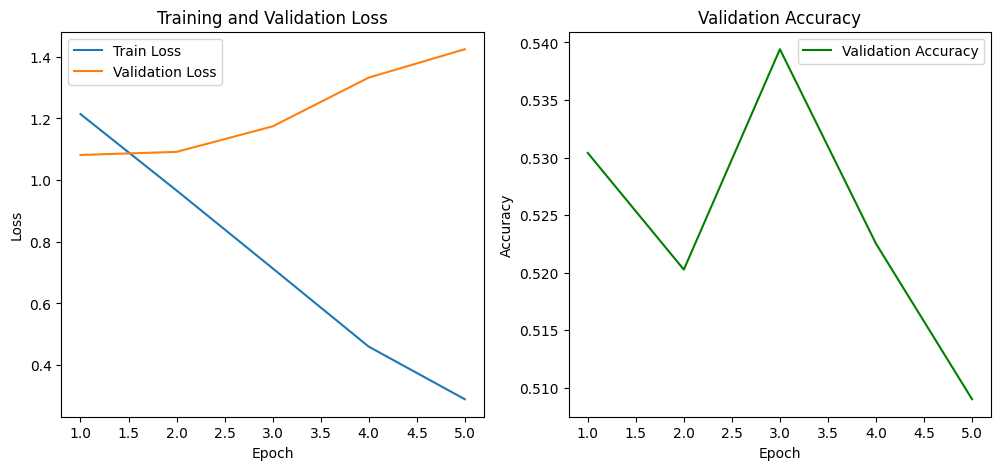

In [ ]:
# Plot grafik loss dan accuracy
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(range(1,num_epochs+1), train_losses, label="Train Loss")
plt.plot(range(1,num_epochs+1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.subplot(1,2,2)
plt.plot(range(1,num_epochs+1), val_accuracies, label="Validation Accuracy", color="green")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy")
plt.legend()
plt.show()

In [ ]:
# Evaluasi final
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=labels))

Classification Report:
              precision    recall  f1-score   support

      others       0.66      0.67      0.67       249
      kontra       0.44      0.45      0.44       238
      netral       0.50      0.47      0.48       268
         pro       0.38      0.39      0.39       133

    accuracy                           0.51       888
   macro avg       0.49      0.50      0.49       888
weighted avg       0.51      0.51      0.51       888



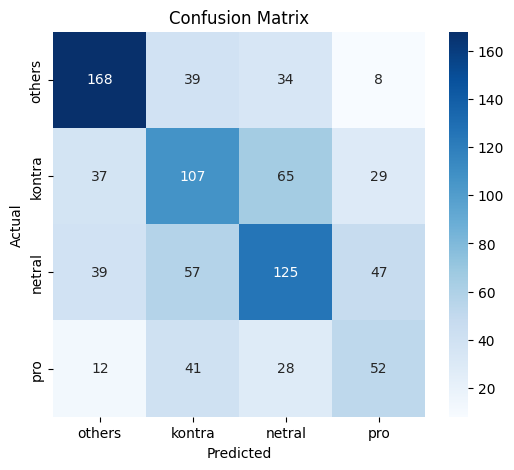

In [ ]:
# Plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()